In [1]:
import gc
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

gc.collect()


0

In [2]:
# FRED API 키 필요하면 설정
FRED_API_KEY = "ea968479ab4b371d4c469cd5537162ab"

# Analysis start date parameter
START_DATE = "2000-01-01"


def get_fred_series(series_id, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json"
    }
    resp = requests.get(url, params=params)
    data = resp.json()["observations"]
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df.set_index("date", inplace=True)
    return df

# 장단기 금리차

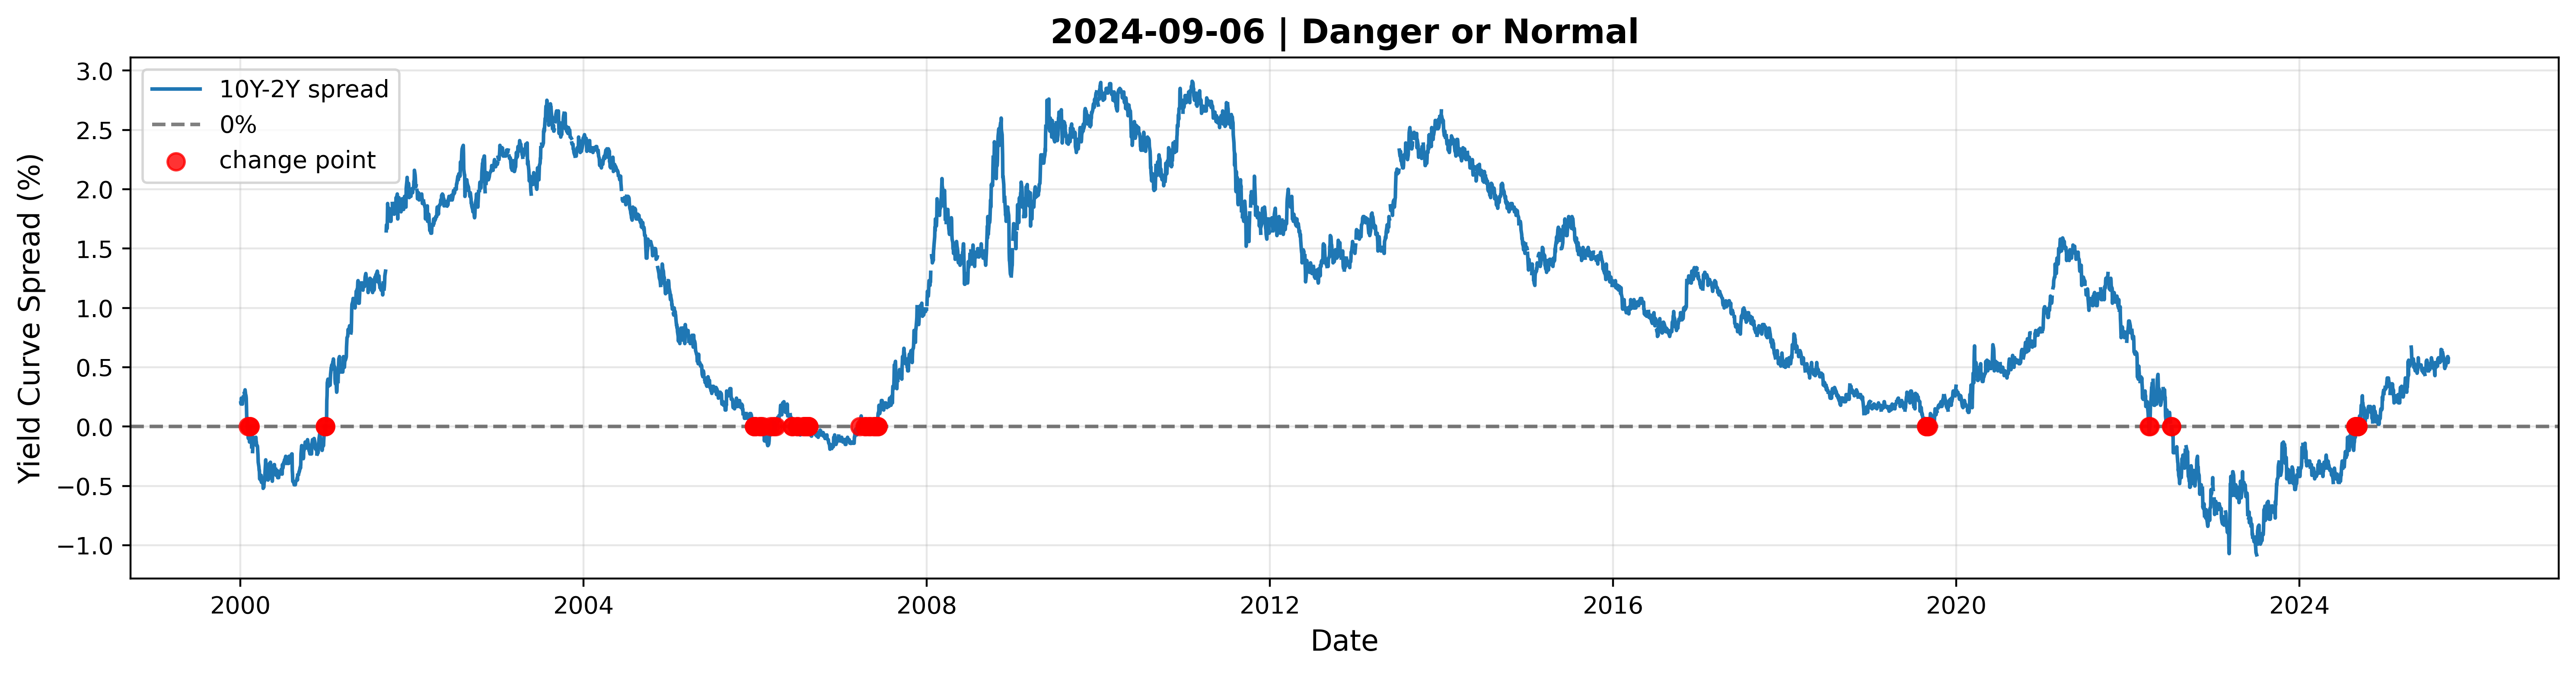

4477

In [3]:
# 10년 만기 국채 금리 :contentReference[oaicite:4]{index=4}
df_10y = get_fred_series("DGS10", FRED_API_KEY)
df_2y = get_fred_series("DGS2", FRED_API_KEY)   # 2년 만기 국채 금리
df_spread = df_10y.join(df_2y, lsuffix="_10y", rsuffix="_2y")
df_spread["spread_10y_2y"] = df_spread["value_10y"] - df_spread["value_2y"]

sign_df = pd.DataFrame(
    np.sign(df_spread['spread_10y_2y'][START_DATE:].dropna()).diff()).dropna()

plt.figure(figsize=(15, 4), dpi=400)
plt.plot(df_spread[START_DATE:]["spread_10y_2y"],
         label='10Y-2Y spread', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='0%')

# 부호 변화 지점 표시 (y=0에 고정)
change_points = sign_df[sign_df['spread_10y_2y'] != 0]
if not change_points.empty:
    plt.scatter(change_points.index, [
                0] * len(change_points), color='red', s=50, alpha=0.8, zorder=5, label='change point')

if change_points.iloc[-1, -1]>0:
    plt.title(
        f'{change_points.index[-1].strftime("%Y-%m-%d")} | Danger or Normal', fontsize=14, fontweight='bold')
    
else:
        plt.title(
        f'{change_points.index[-1].strftime("%Y-%m-%d")} | Warning', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yield Curve Spread (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# 현재 금리 현황

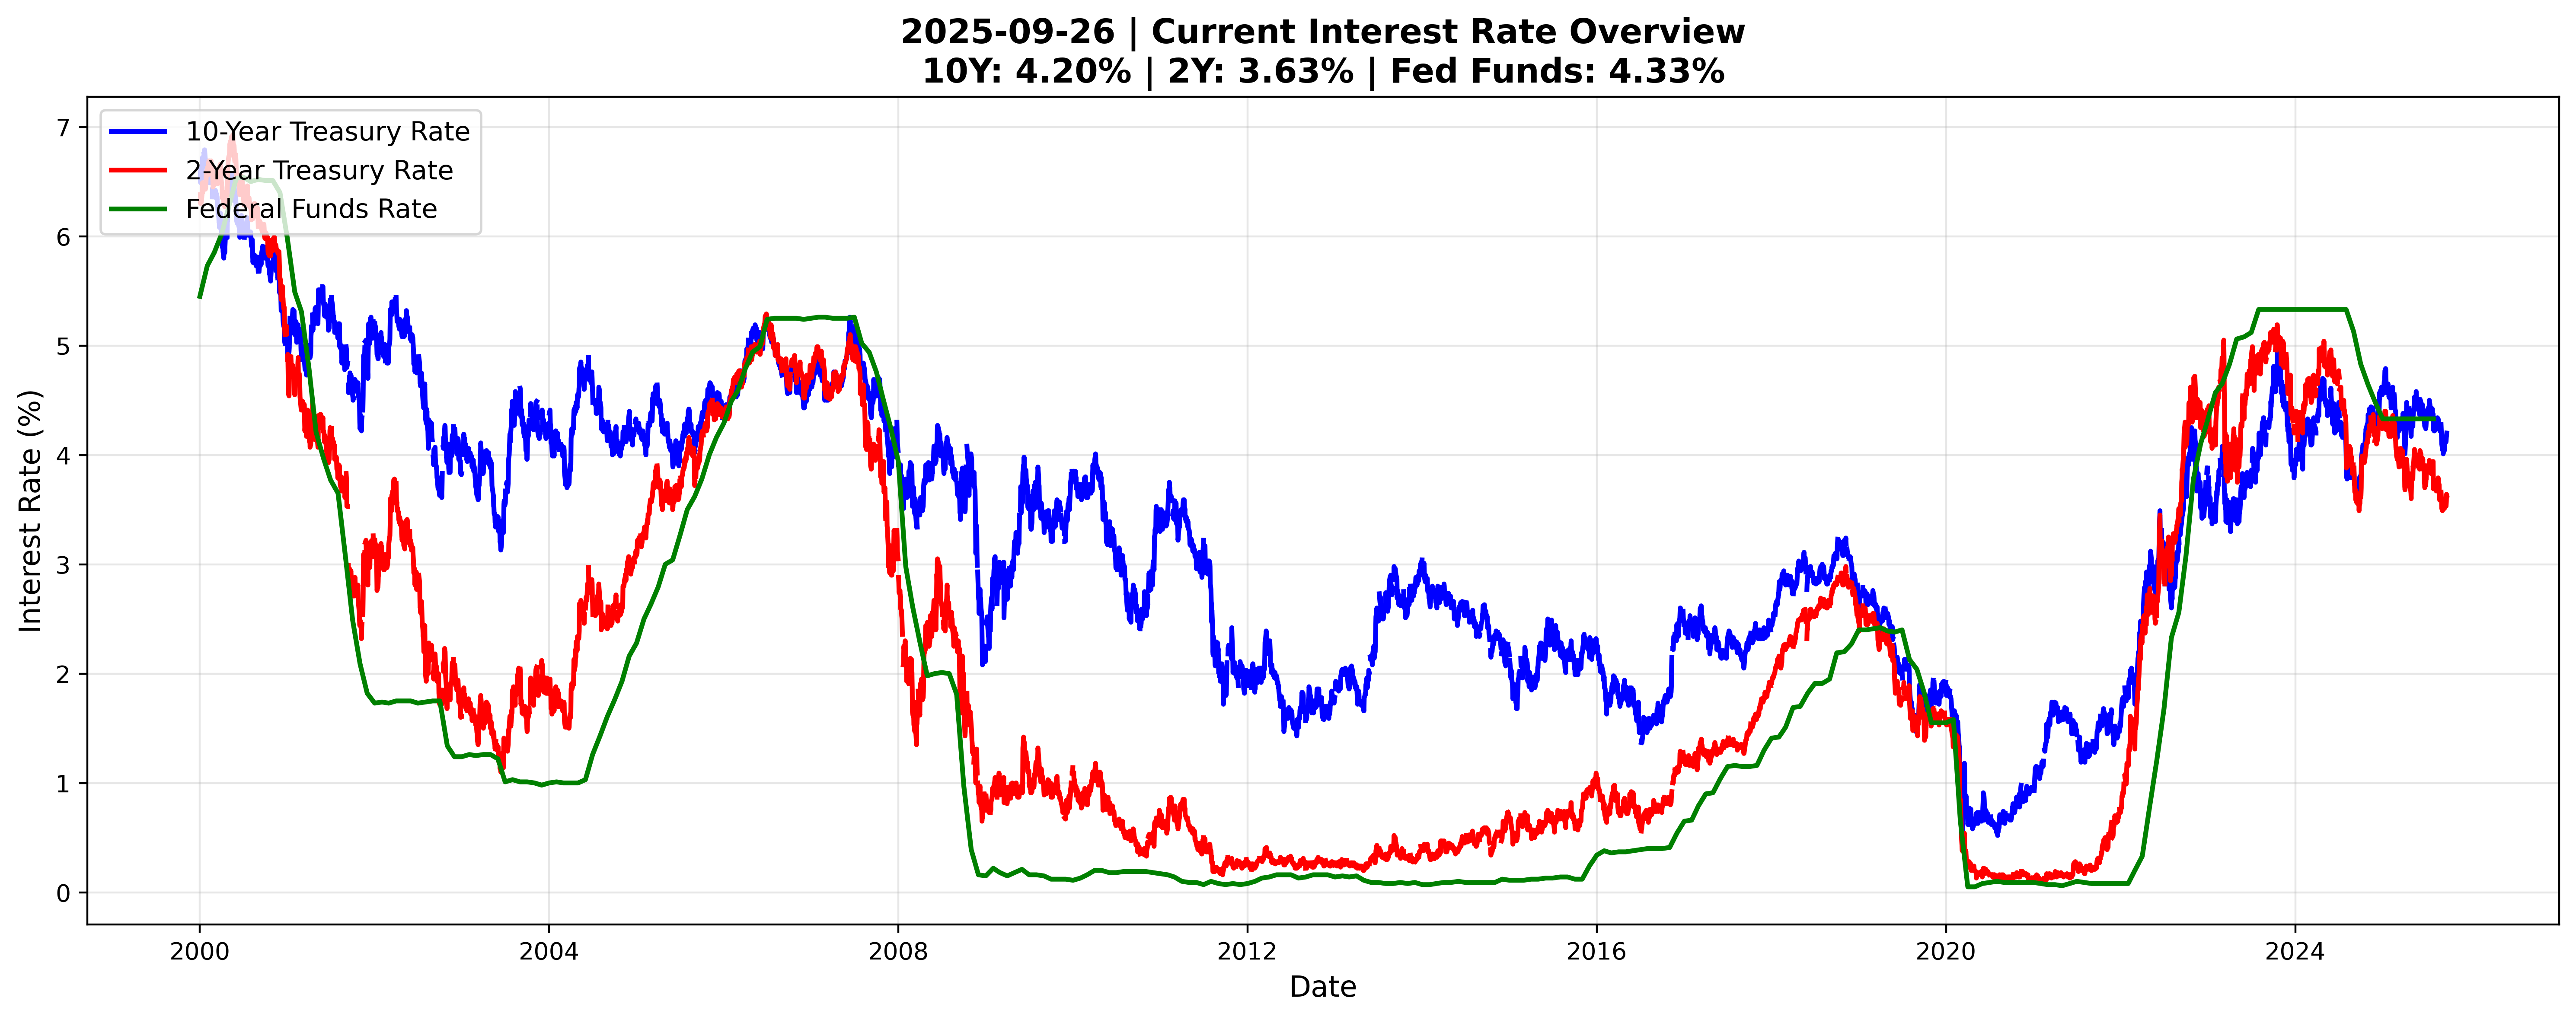

4377

In [4]:
# Current Interest Rate Overview - Comprehensive Chart
# 10-year, 2-year Treasury rates and Federal Funds Rate
df_fed_funds = get_fred_series("FEDFUNDS", FRED_API_KEY)  # Federal Funds Rate

plt.figure(figsize=(15, 6), dpi=400)

# 10-year Treasury Rate
plt.plot(df_10y[START_DATE:].index, df_10y[START_DATE:]["value"], 
         label='10-Year Treasury Rate', linewidth=2, color='blue')

# 2-year Treasury Rate  
plt.plot(df_2y[START_DATE:].index, df_2y[START_DATE:]["value"], 
         label='2-Year Treasury Rate', linewidth=2, color='red')

# Federal Funds Rate
plt.plot(df_fed_funds[START_DATE:].index, df_fed_funds[START_DATE:]["value"], 
         label='Federal Funds Rate', linewidth=2, color='green')

# Current rate levels display
latest_date = df_10y.index[-1]
plt.title(f'{latest_date.strftime("%Y-%m-%d")} | Current Interest Rate Overview\n'
          f'10Y: {df_10y.iloc[-1]["value"]:.2f}% | '
          f'2Y: {df_2y.iloc[-1]["value"]:.2f}% | '
          f'Fed Funds: {df_fed_funds.iloc[-1]["value"]:.2f}%', 
          fontsize=14, fontweight='bold')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# S&P500 30일 지수이동평균선

[*********************100%***********************]  2 of 2 completed


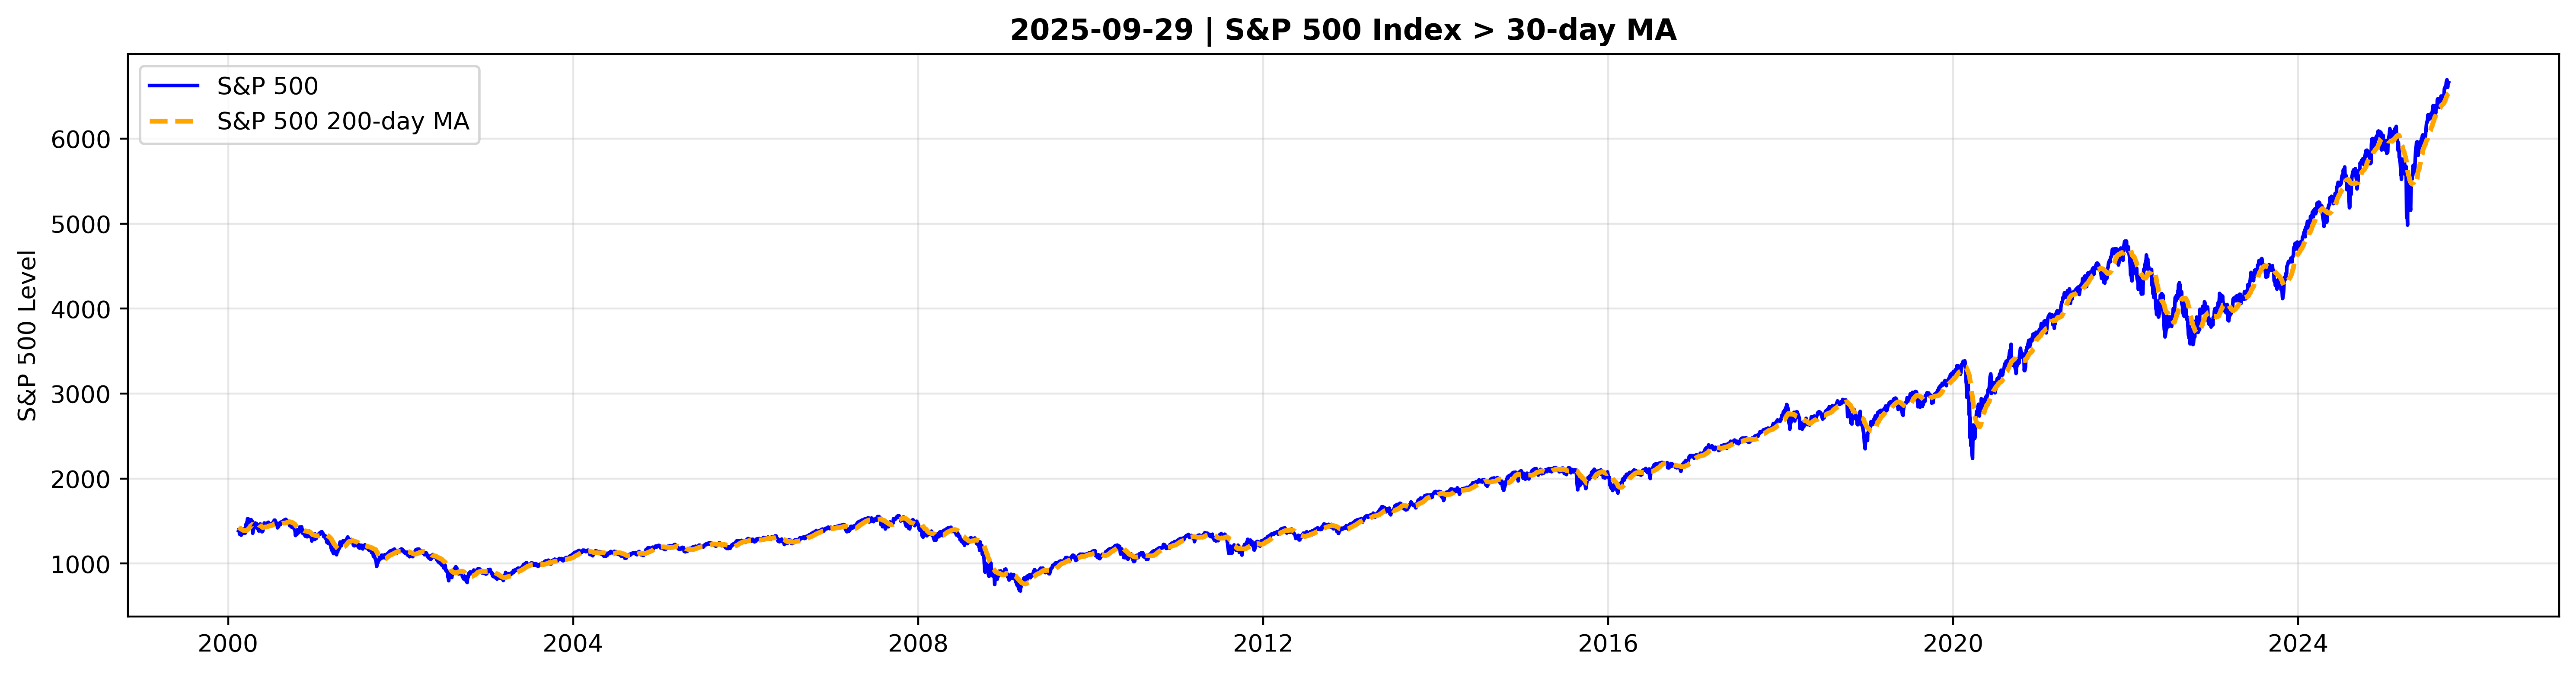

3987

In [5]:
tickers = ["GC=F", "^GSPC"]
data = yf.download(tickers, start='2000-01-01', auto_adjust=False)
df_sp500 = pd.DataFrame(data['Adj Close']['^GSPC'].copy())
df_sp500["sp500_ma200"] = df_sp500.dropna().rolling(window=30).mean()
df_sp500 = df_sp500.dropna()

plt.figure(figsize=(15, 4), dpi=400)

# 2. S&P 500 with 200-day Moving Average
plt.plot(df_sp500[START_DATE:].index, df_sp500[START_DATE:]["^GSPC"],
         label='S&P 500', linewidth=1.5, color='blue')
plt.plot(df_sp500[START_DATE:].index, df_sp500[START_DATE:]["sp500_ma200"],
         label='S&P 500 200-day MA', linewidth=2, color='orange', linestyle='--')
if df_sp500.iloc[-1, 0] > df_sp500.iloc[-1, 1]:
    plt.title(
        f'{df_sp500.index[-1].strftime("%Y-%m-%d")} | S&P 500 Index > 30-day MA', fontweight='bold')
else:
    plt.title(
        f'{df_sp500.index[-1].strftime("%Y-%m-%d")} | S&P 500 Index < 30-day MA', fontweight='bold')
plt.ylabel('S&P 500 Level')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# 시설투자와 주식시장

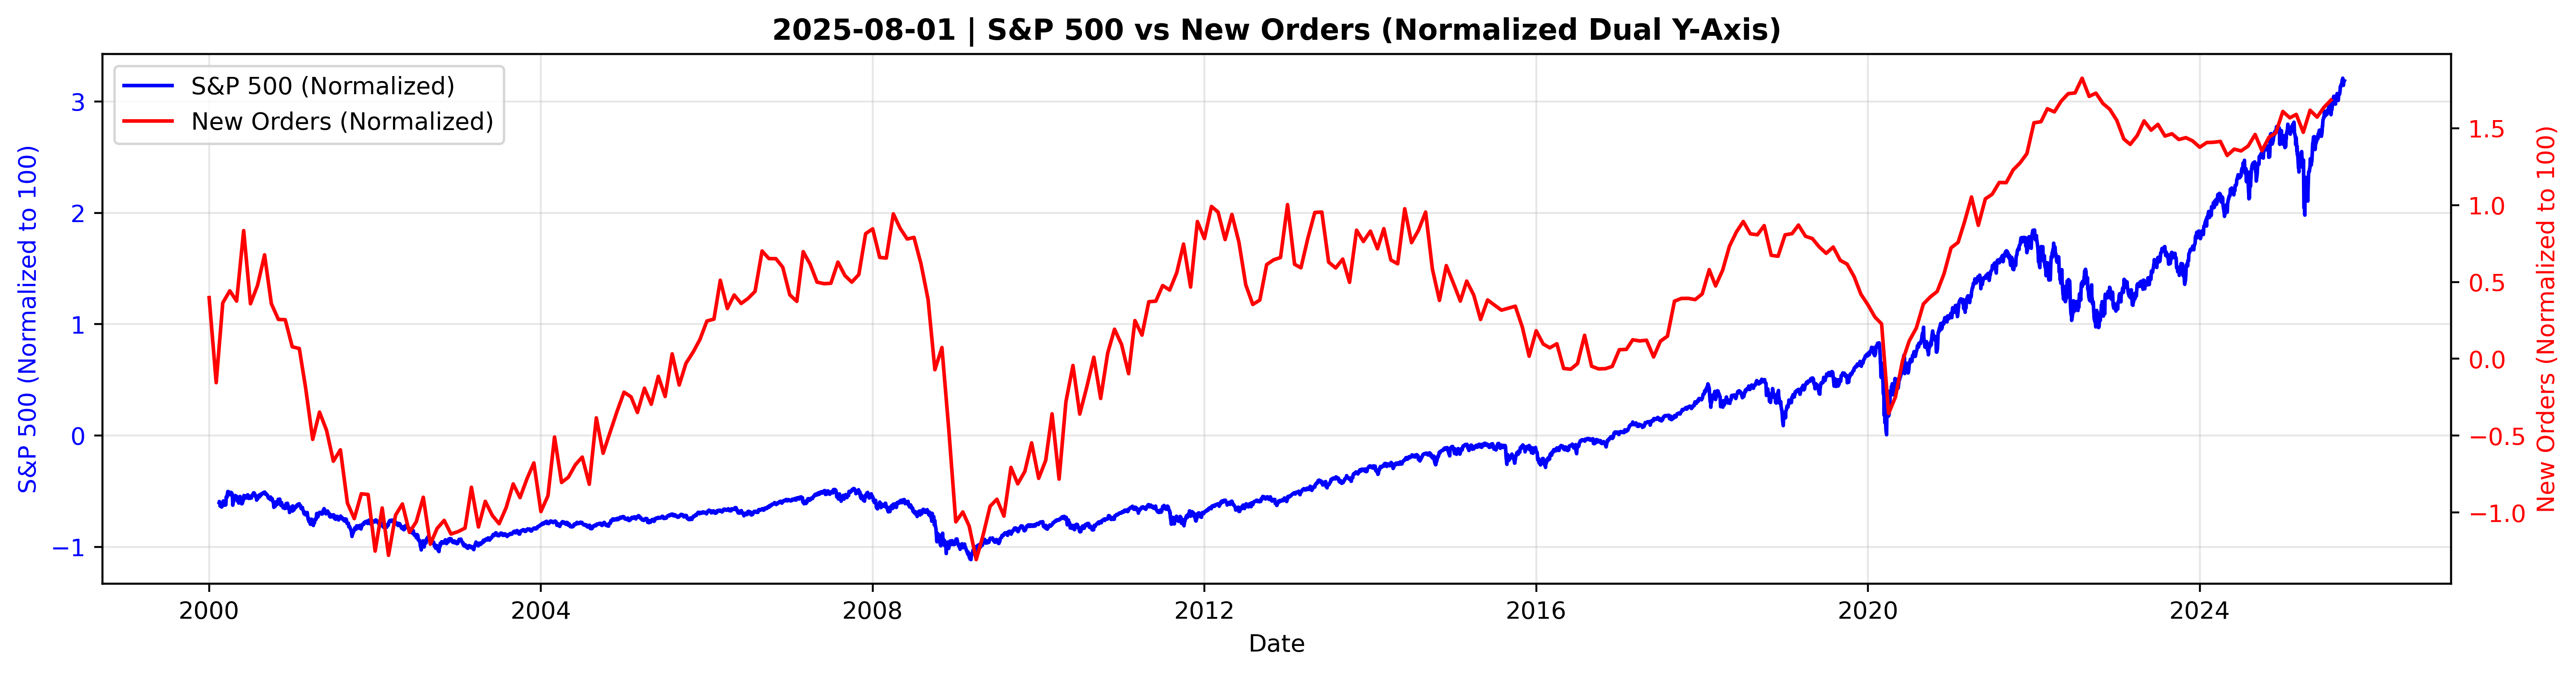

15

In [6]:
df_neworder = get_fred_series("NEWORDER", FRED_API_KEY)

# Normalize both series to 100 at the start date
sp500_norm = (df_sp500["^GSPC"] - df_sp500["^GSPC"].mean()) / df_sp500["^GSPC"].std()
neworder_norm = (df_neworder['value'] - df_neworder['value'].mean()) / df_neworder['value'].std()

sp500_norm = sp500_norm.loc['2000-01-01':]
neworder_norm = neworder_norm.loc['2000-01-01':]
# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(15, 4), dpi=400)

# Left y-axis: S&P 500 (Normalized)
color1 = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 (Normalized to 100)', color=color1)
line1 = ax1.plot(sp500_norm.index, sp500_norm, 
                 color=color1, linewidth=1.5, label='S&P 500 (Normalized)')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Right y-axis: New Orders (Normalized)
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('New Orders (Normalized to 100)', color=color2)
line2 = ax2.plot(neworder_norm.index, neworder_norm, 
                 color=color2, linewidth=1.5, label='New Orders (Normalized)')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title(f'{neworder_norm.index[-1].strftime("%Y-%m-%d")} | S&P 500 vs New Orders (Normalized Dual Y-Axis)', fontweight='bold')
plt.tight_layout()
plt.show()

gc.collect()

# VIX Index

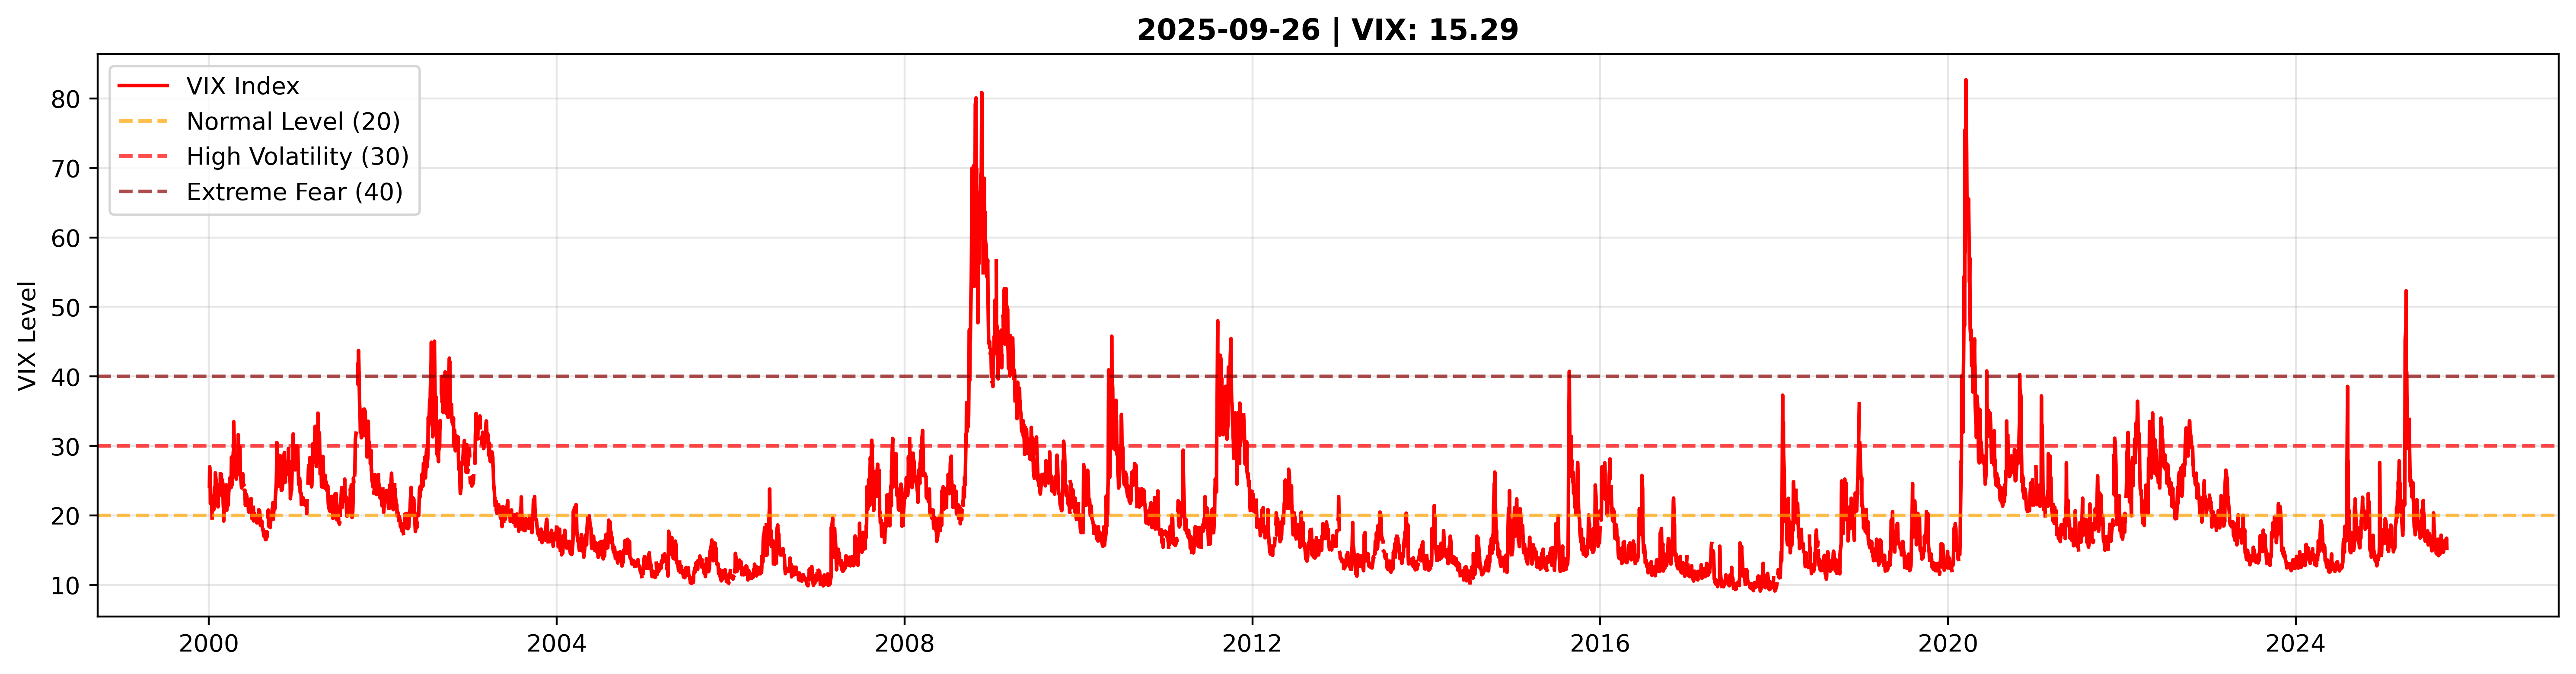

4561

In [7]:
df_vix = get_fred_series("VIXCLS", FRED_API_KEY)  # VIX Volatility Index
# 미국과 한국 가계부채/GDP 비율 비교 시각화
plt.figure(figsize=(15, 4), dpi=400)
# 1. VIX Index (Volatility)
plt.plot(df_vix[START_DATE:].index, df_vix[START_DATE:]["value"],
         label='VIX Index', linewidth=1.5, color='red')
plt.axhline(y=20, color='orange', linestyle='--',
            alpha=0.7, label='Normal Level (20)')
plt.axhline(y=30, color='red', linestyle='--',
            alpha=0.7, label='High Volatility (30)')
plt.axhline(y=40, color='darkred', linestyle='--',
            alpha=0.7, label='Extreme Fear (40)')
plt.title(
    f'{df_vix.index[-1].strftime("%Y-%m-%d")} | VIX: {df_vix.iloc[-1]["value"]}', fontweight='bold')
plt.ylabel('VIX Level')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# GDP 대비 가계부채

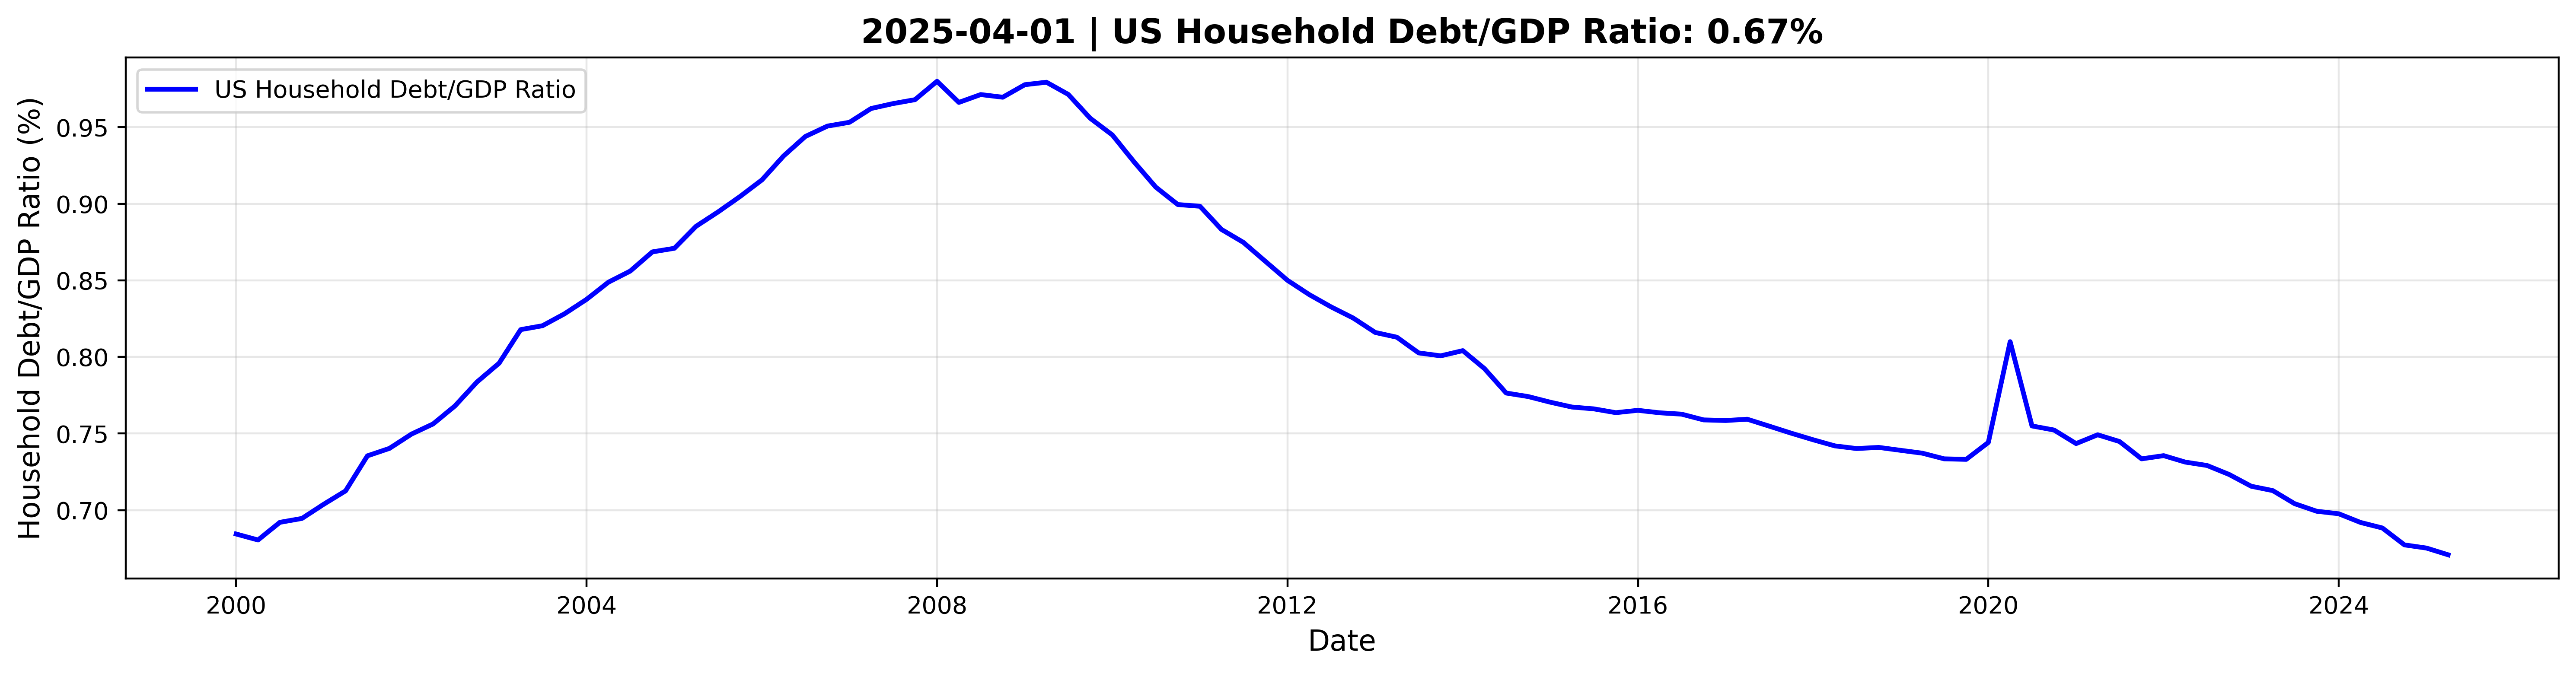

3829

In [8]:
# GDP 대비 가계부채 비율 데이터 가져오기

# 미국 데이터
# 1. 미국 가계부채 (Household Debt)
# Consumer Debt Outstanding
df_us_debt = get_fred_series("CMDEBT", FRED_API_KEY)

# 2. 미국 GDP
df_us_gdp = get_fred_series("GDP", FRED_API_KEY)  # Gross Domestic Product

# 3. 미국 가계부채/GDP 비율 계산
df_us_combined = df_us_debt[START_DATE:]['value'] / \
    df_us_gdp[START_DATE:]['value']

# 미국과 한국 가계부채/GDP 비율 비교 시각화
plt.figure(figsize=(15, 4), dpi=400)

# 미국 데이터 플롯
if 'df_us_combined' in locals():
    plt.plot(df_us_combined.index, df_us_combined,
             label='US Household Debt/GDP Ratio', linewidth=2, color='blue')

plt.title(
    f'{df_us_combined.index[-1].strftime("%Y-%m-%d")} | US Household Debt/GDP Ratio: {df_us_combined.iloc[-1]:.2f}%', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Household Debt/GDP Ratio (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Gold

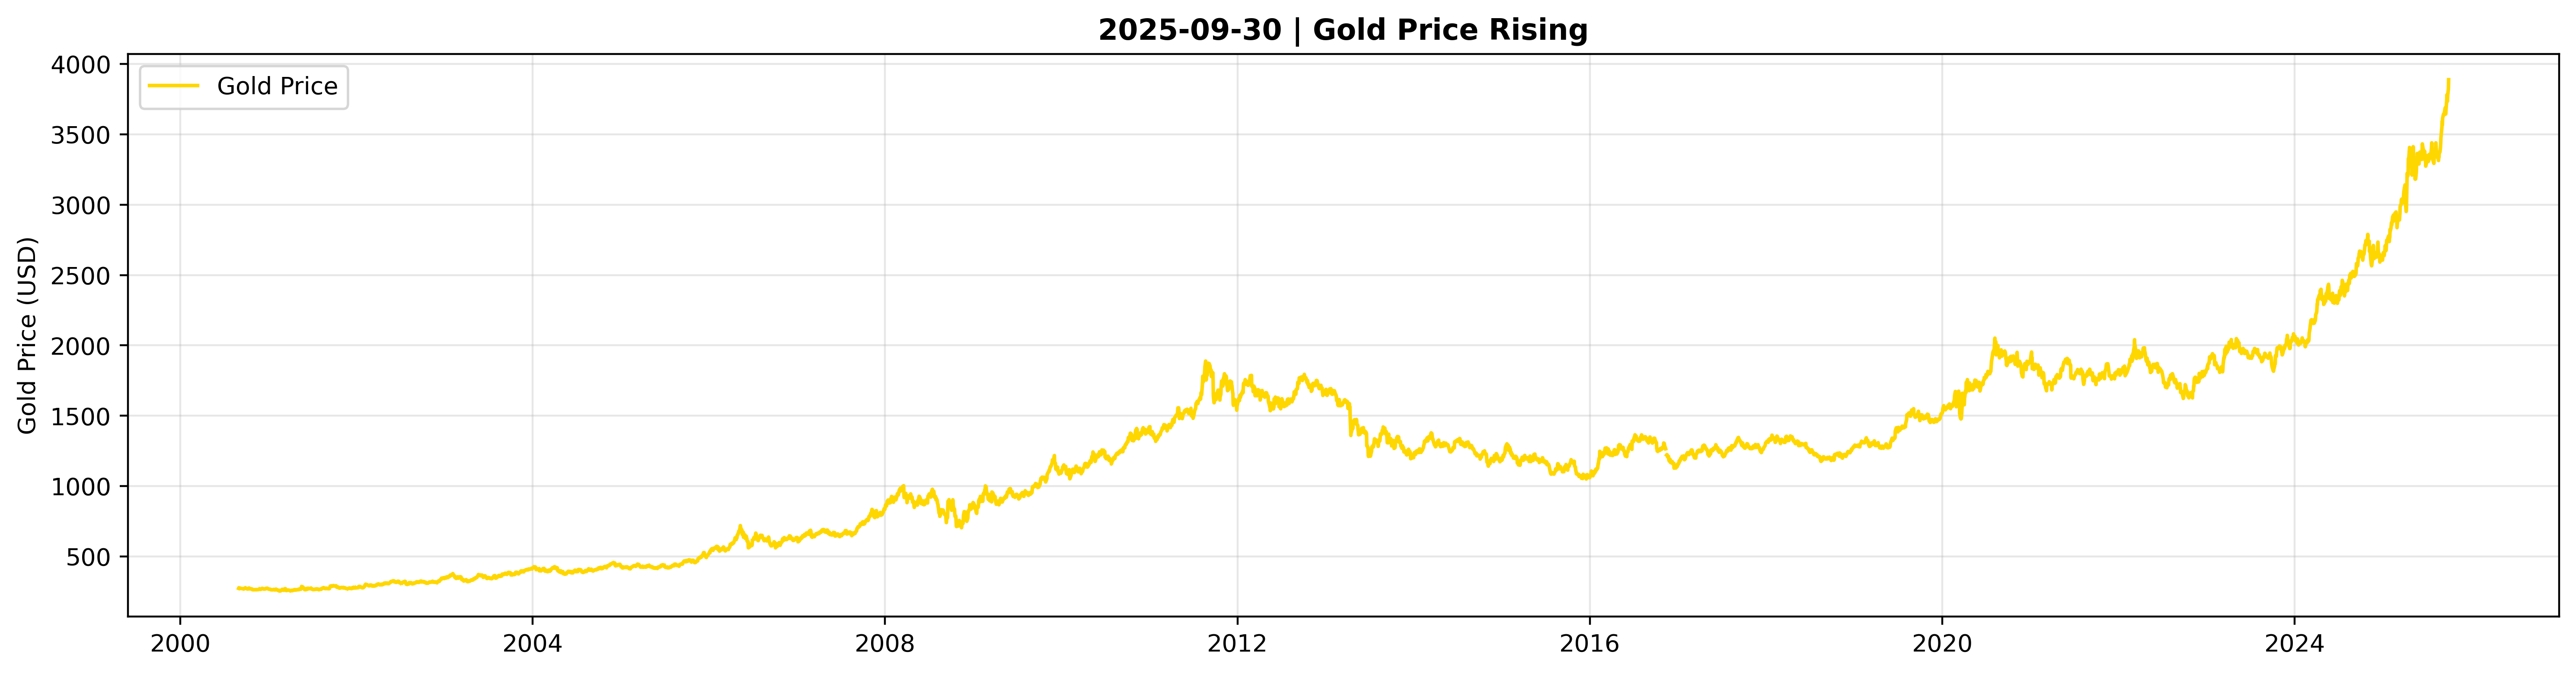

4038

In [9]:
df_gold = pd.DataFrame(data['Adj Close']['GC=F'].copy())

plt.figure(figsize=(15, 4), dpi=400)

# Gold Price Chart
plt.plot(df_gold[START_DATE:].index, df_gold[START_DATE:],
         label='Gold Price', linewidth=1.5, color='gold')
if df_gold.iloc[-1, 0] > df_gold.iloc[-2, 0]:
    plt.title(
        f'{df_gold.index[-1].strftime("%Y-%m-%d")} | Gold Price Rising', fontweight='bold')
else:
    plt.title(
        f'{df_gold.index[-1].strftime("%Y-%m-%d")} | Gold Price Falling', fontweight='bold')
plt.ylabel('Gold Price (USD)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Unemployment Rate

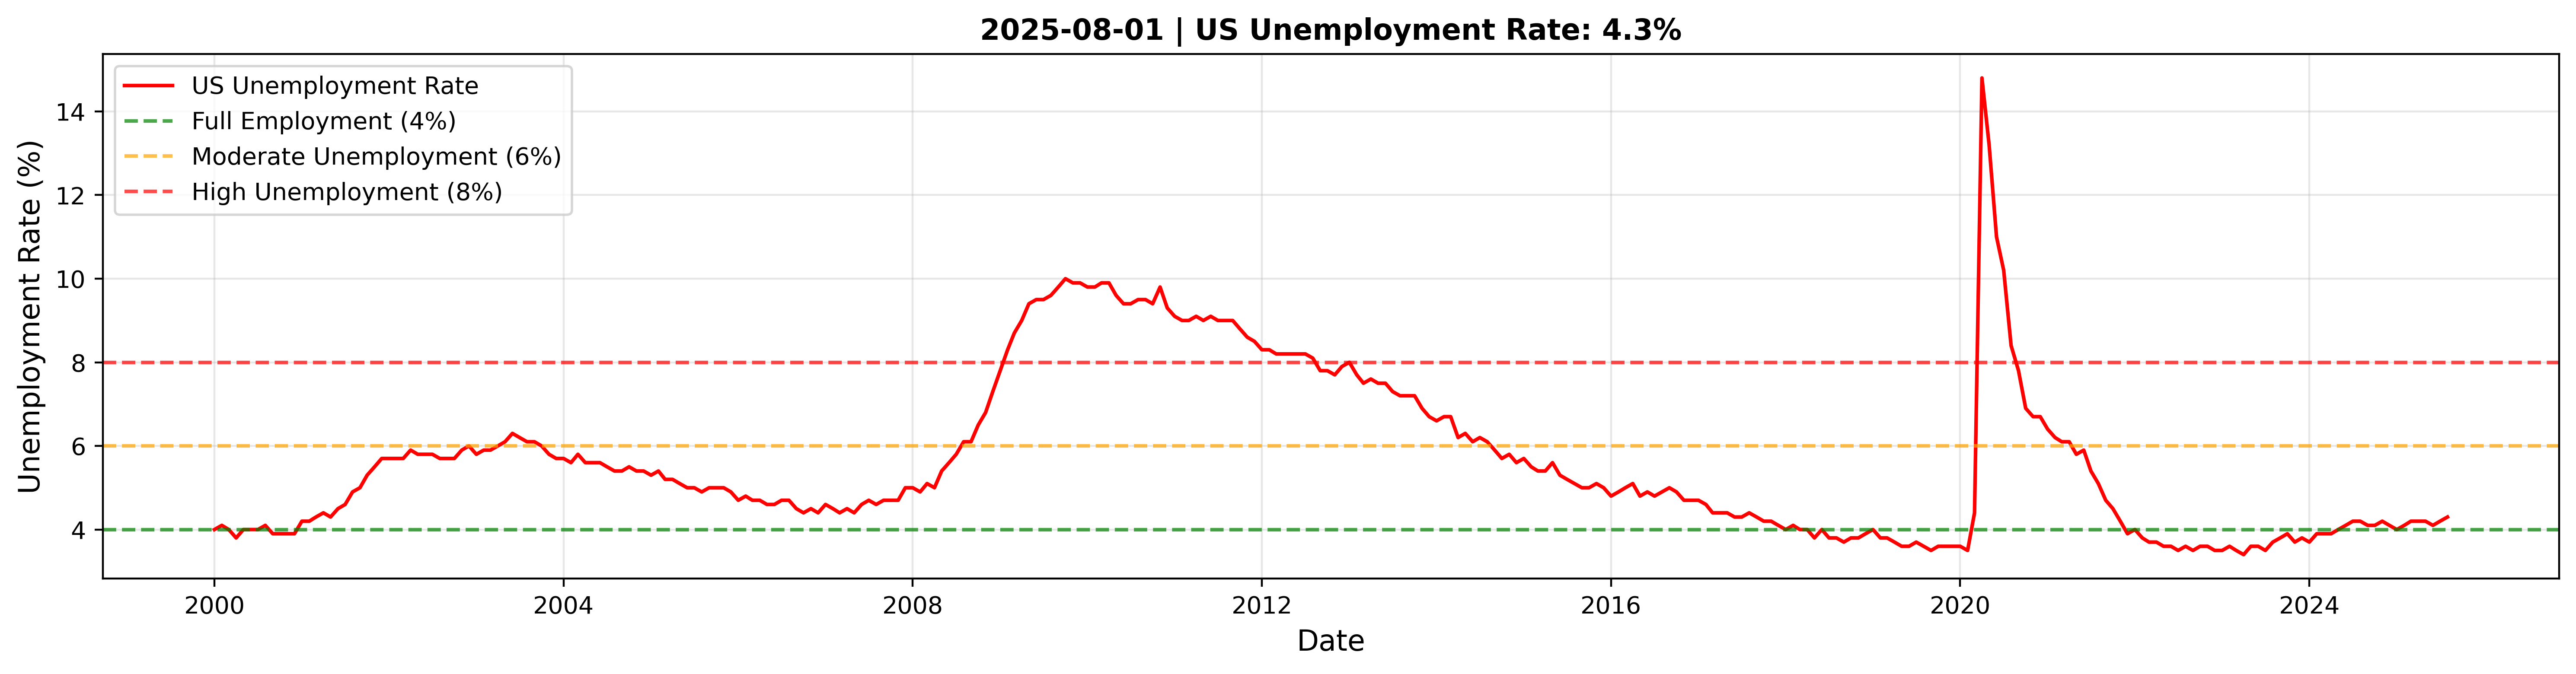

4370

In [10]:
# Unemployment Rate Data from FRED
# Get US Unemployment Rate
df_unemployment = get_fred_series("UNRATE", FRED_API_KEY)  # US Unemployment Rate

# Unemployment Rate Visualization
plt.figure(figsize=(15, 4), dpi=400)

# Plot Unemployment Rate
plt.plot(df_unemployment[START_DATE:].index, df_unemployment[START_DATE:]["value"], 
         label='US Unemployment Rate', linewidth=1.5, color='red')

# Add reference lines for different unemployment levels
plt.axhline(y=4.0, color='green', linestyle='--', alpha=0.7, label='Full Employment (4%)')
plt.axhline(y=6.0, color='orange', linestyle='--', alpha=0.7, label='Moderate Unemployment (6%)')
plt.axhline(y=8.0, color='red', linestyle='--', alpha=0.7, label='High Unemployment (8%)')

plt.title(f'{df_unemployment.index[-1].strftime("%Y-%m-%d")} | US Unemployment Rate: {df_unemployment.iloc[-1]["value"]:.1f}%', 
          fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Corporate Debt Growth Rate

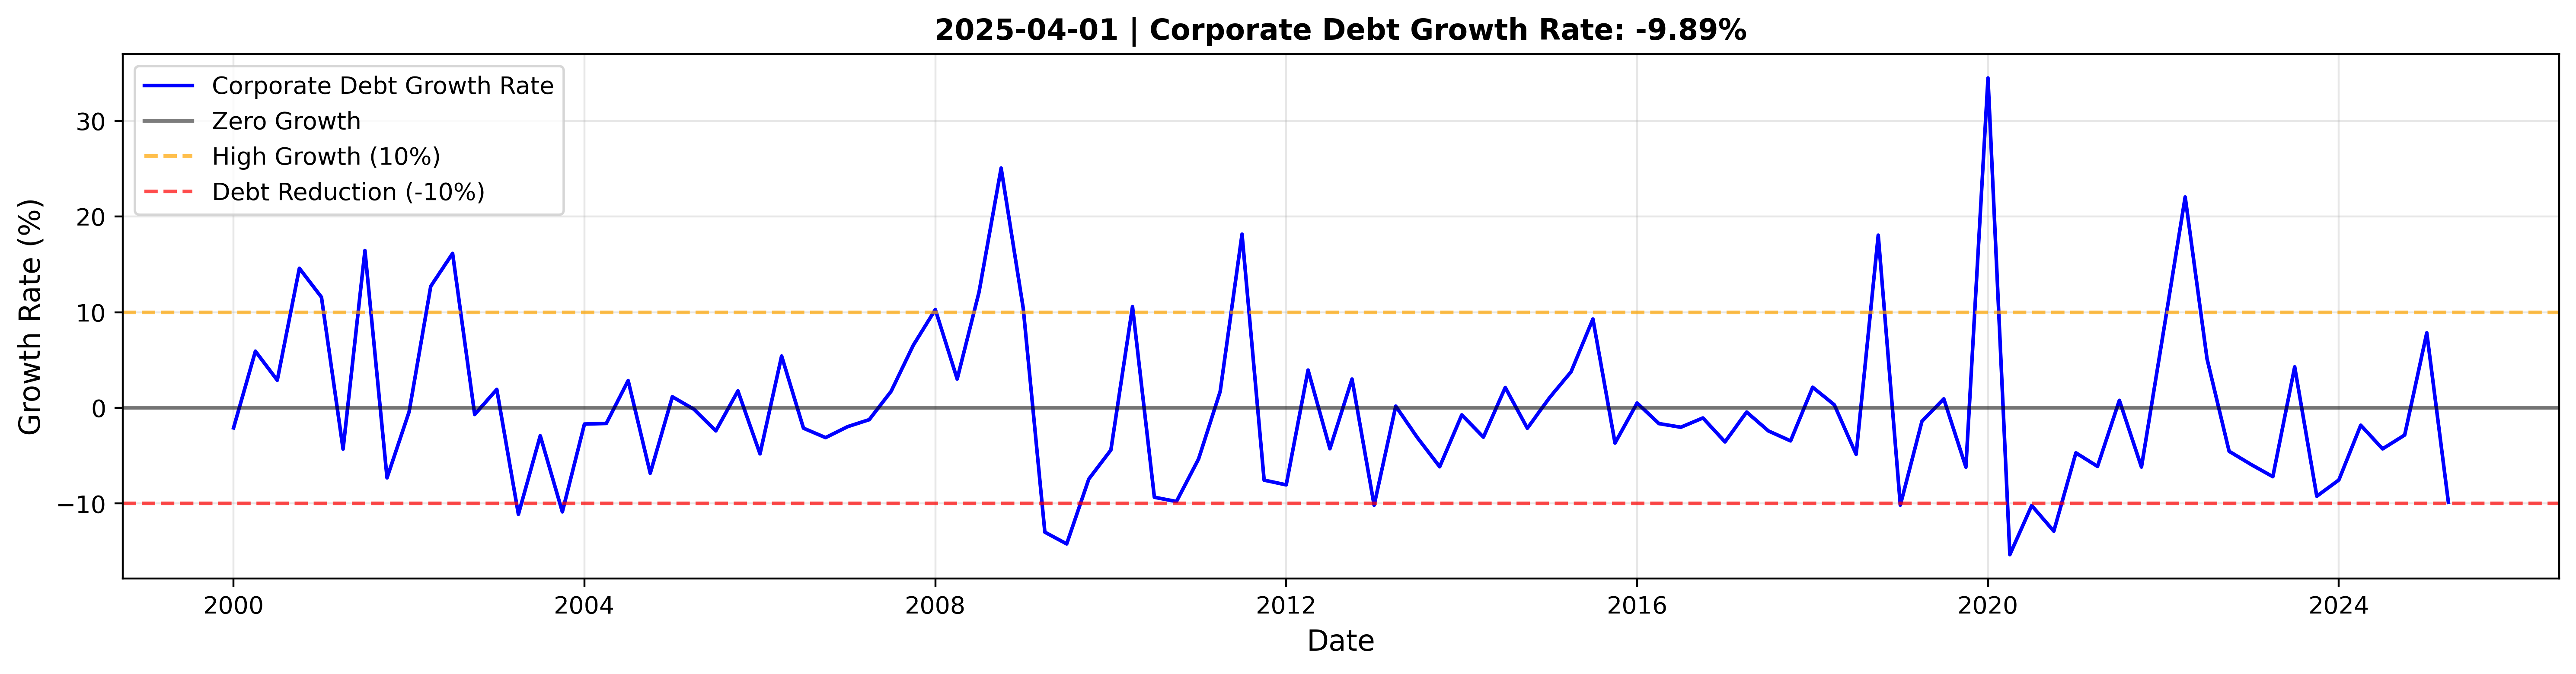

4287

In [11]:
# 기업 부채 증가율 (Corporate Debt Growth Rate)
df_corporate_debt = get_fred_series("NCBCMDPMVCE", FRED_API_KEY)

df_corporate_debt_growth = df_corporate_debt['value'].dropna().pct_change() * 100

plt.figure(figsize=(15, 4), dpi=400)
plt.plot(df_corporate_debt_growth[START_DATE:].index, df_corporate_debt_growth[START_DATE:], 
         label='Corporate Debt Growth Rate', linewidth=1.5, color='blue')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Zero Growth')
plt.axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='High Growth (10%)')
plt.axhline(y=-10, color='red', linestyle='--', alpha=0.7, label='Debt Reduction (-10%)')
plt.title(f'{df_corporate_debt_growth.index[-1].strftime("%Y-%m-%d")} | Corporate Debt Growth Rate: {df_corporate_debt_growth.iloc[-1]:.2f}%', fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Consumer Confidence Index

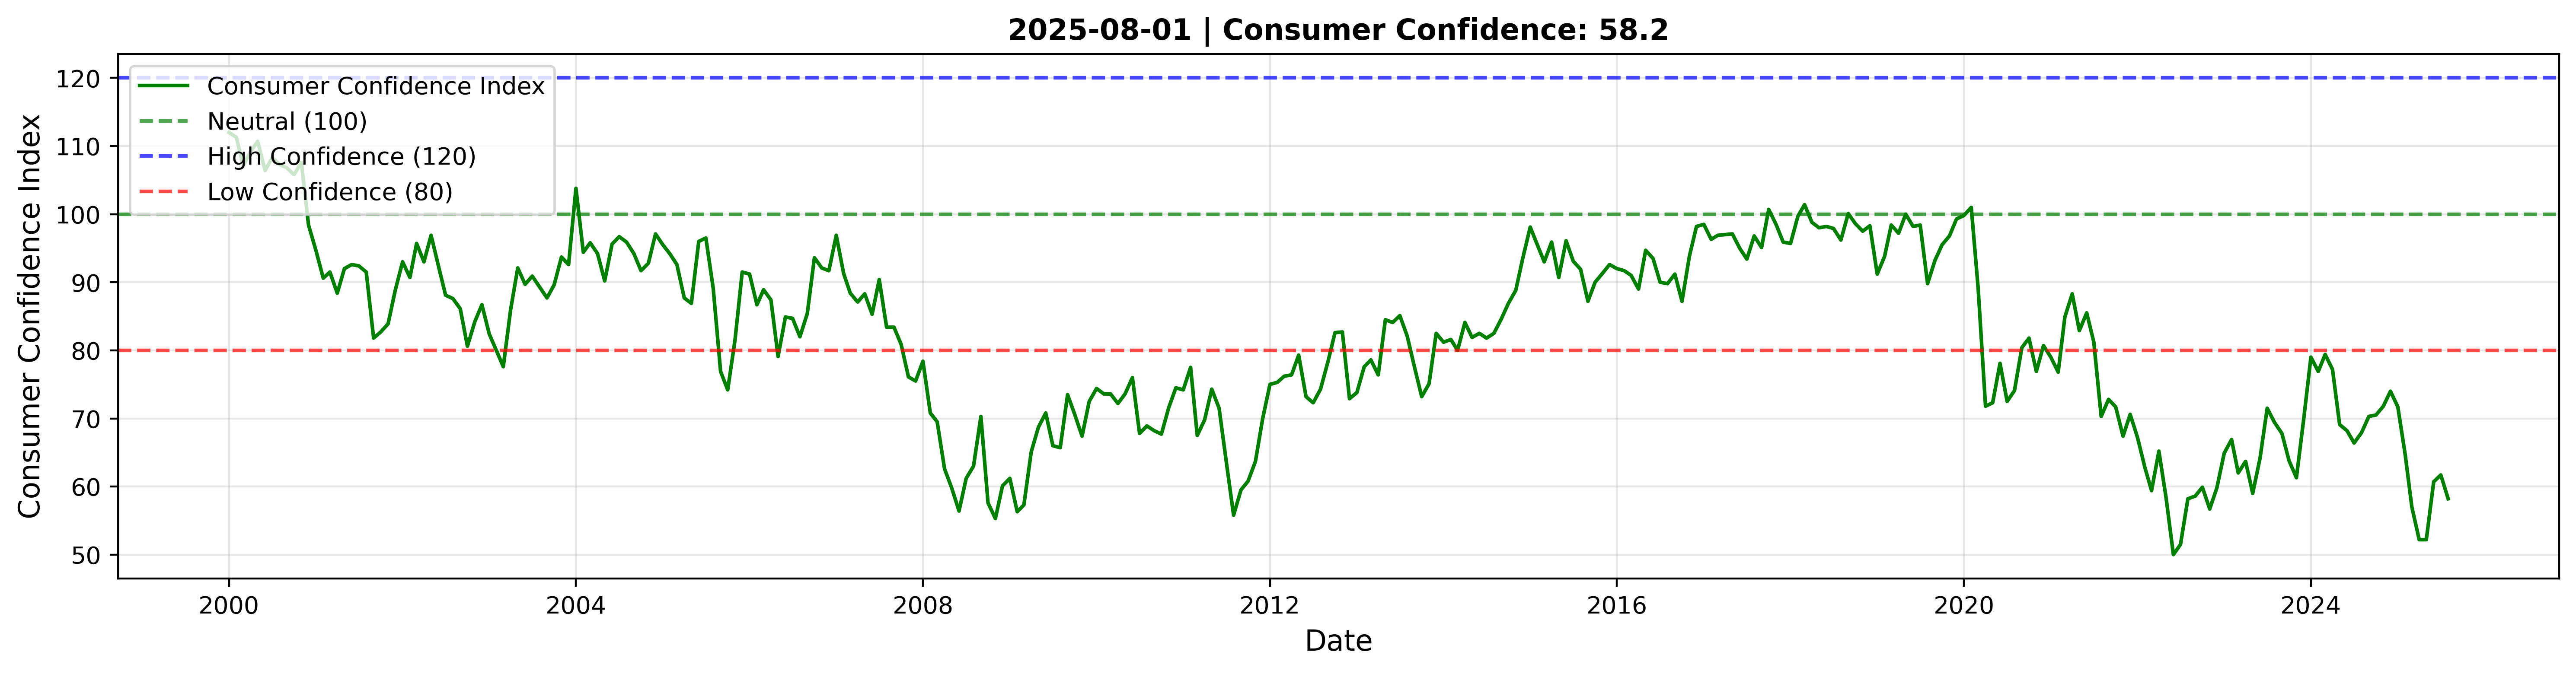

4527

In [12]:
# 소비자신뢰지수 (Consumer Confidence Index)
df_consumer_confidence = get_fred_series("UMCSENT", FRED_API_KEY)

plt.figure(figsize=(15, 4), dpi=400)
plt.plot(df_consumer_confidence[START_DATE:].index, df_consumer_confidence[START_DATE:]["value"], 
         label='Consumer Confidence Index', linewidth=1.5, color='green')
plt.axhline(y=100, color='green', linestyle='--', alpha=0.7, label='Neutral (100)')
plt.axhline(y=120, color='blue', linestyle='--', alpha=0.7, label='High Confidence (120)')
plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Low Confidence (80)')
plt.title(f'{df_consumer_confidence.index[-1].strftime("%Y-%m-%d")} | Consumer Confidence: {df_consumer_confidence.iloc[-1]["value"]:.1f}', fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Consumer Confidence Index', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Capacity Utilization

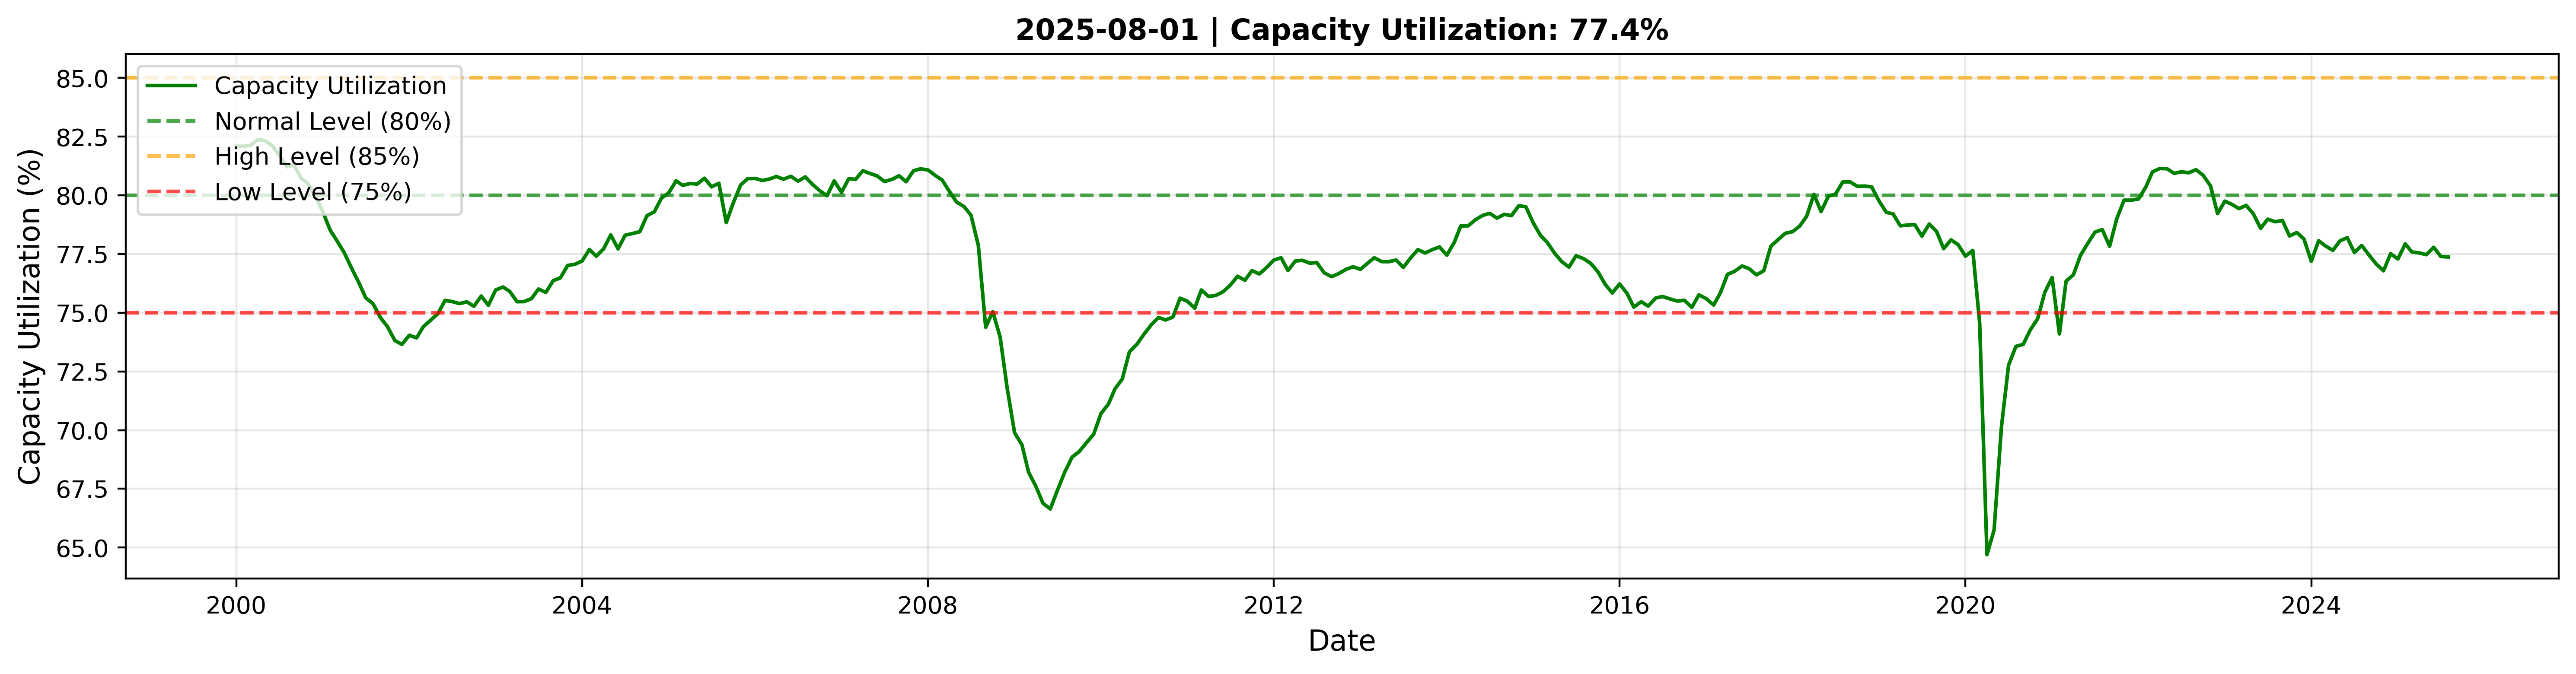

4696

In [13]:
# 설비가동률 (Capacity Utilization)
df_capacity = get_fred_series("TCU", FRED_API_KEY)

plt.figure(figsize=(15, 4), dpi=400)
plt.plot(df_capacity[START_DATE:].index, df_capacity[START_DATE:]["value"], 
         label='Capacity Utilization', linewidth=1.5, color='green')
plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Normal Level (80%)')
plt.axhline(y=85, color='orange', linestyle='--', alpha=0.7, label='High Level (85%)')
plt.axhline(y=75, color='red', linestyle='--', alpha=0.7, label='Low Level (75%)')
plt.title(f'{df_capacity.index[-1].strftime("%Y-%m-%d")} | Capacity Utilization: {df_capacity.iloc[-1]["value"]:.1f}%', fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Capacity Utilization (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

#  Freight Index

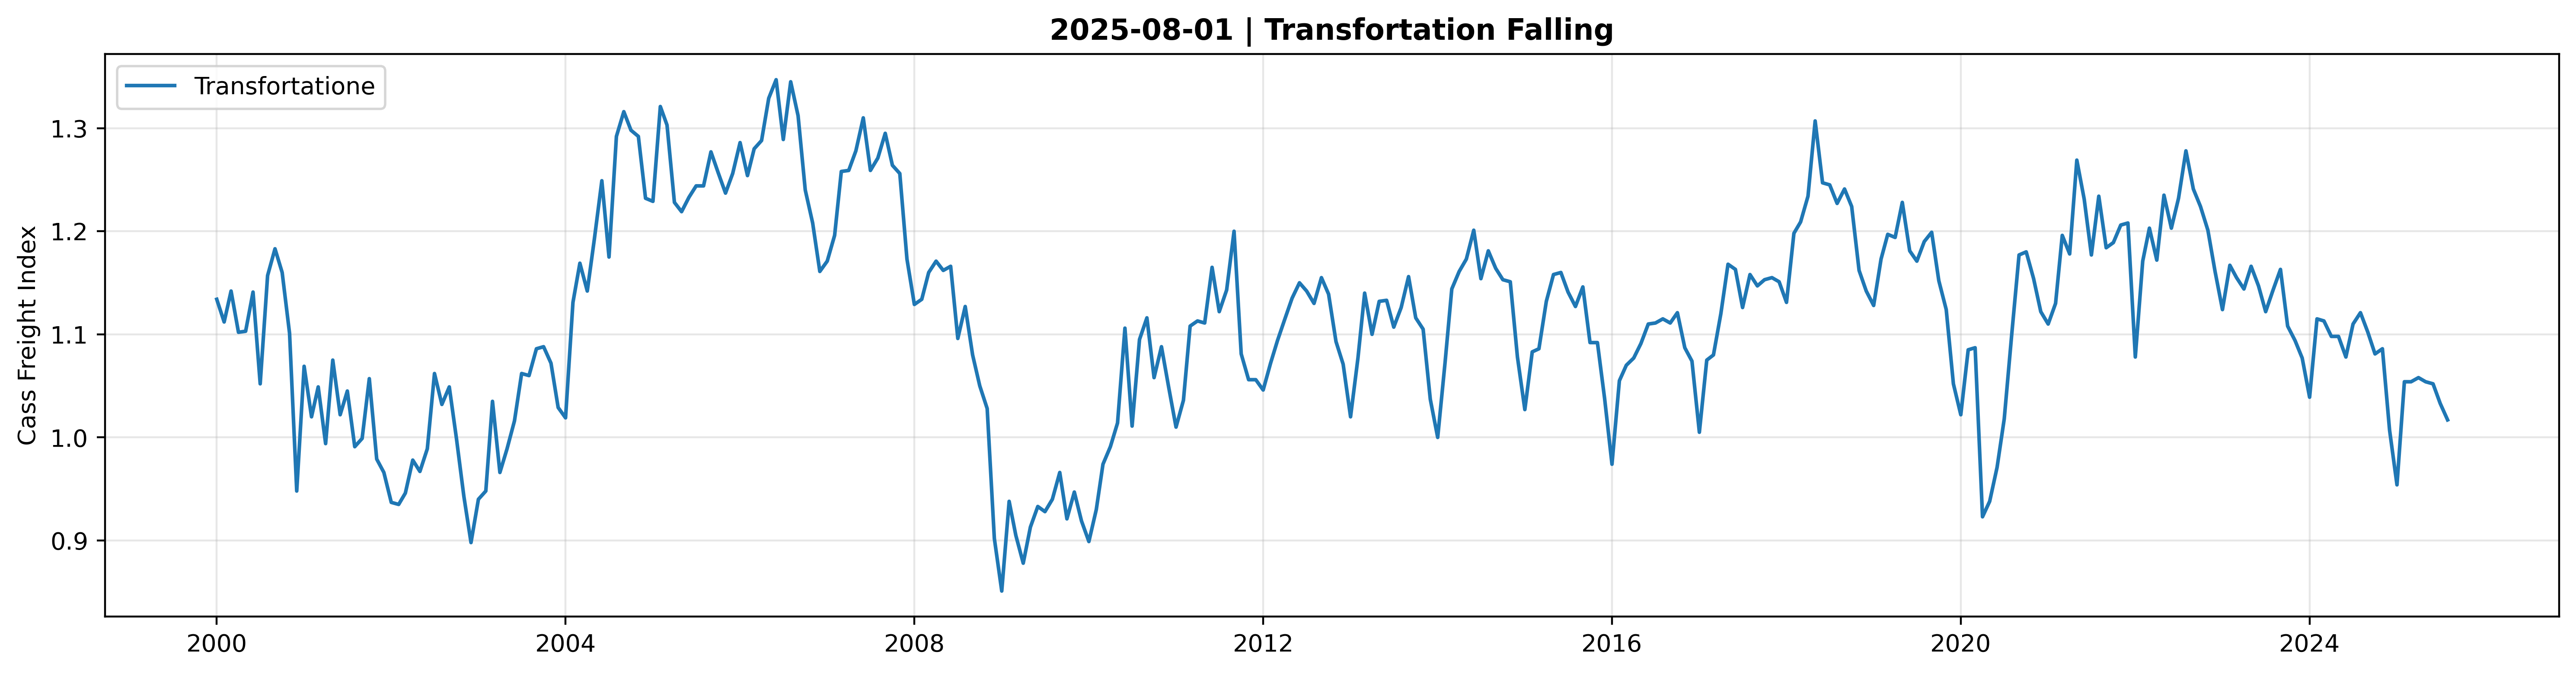

3709

In [14]:
df_cass = get_fred_series("FRGSHPUSM649NCIS", FRED_API_KEY)

plt.figure(figsize=(15, 4), dpi=400)

# Gold Price Chart
plt.plot(df_cass[START_DATE:].index, df_cass[START_DATE:]['value'],
         label='Transfortatione', linewidth=1.5)
if df_cass.iloc[-1, 0] > df_cass.iloc[-2, 0]:
    plt.title(
        f'{df_cass.index[-1].strftime("%Y-%m-%d")} | Transfortation Rising', fontweight='bold')
else:
    plt.title(
        f'{df_cass.index[-1].strftime("%Y-%m-%d")} | Transfortation Falling', fontweight='bold')
plt.ylabel('Cass Freight Index')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Stress Index

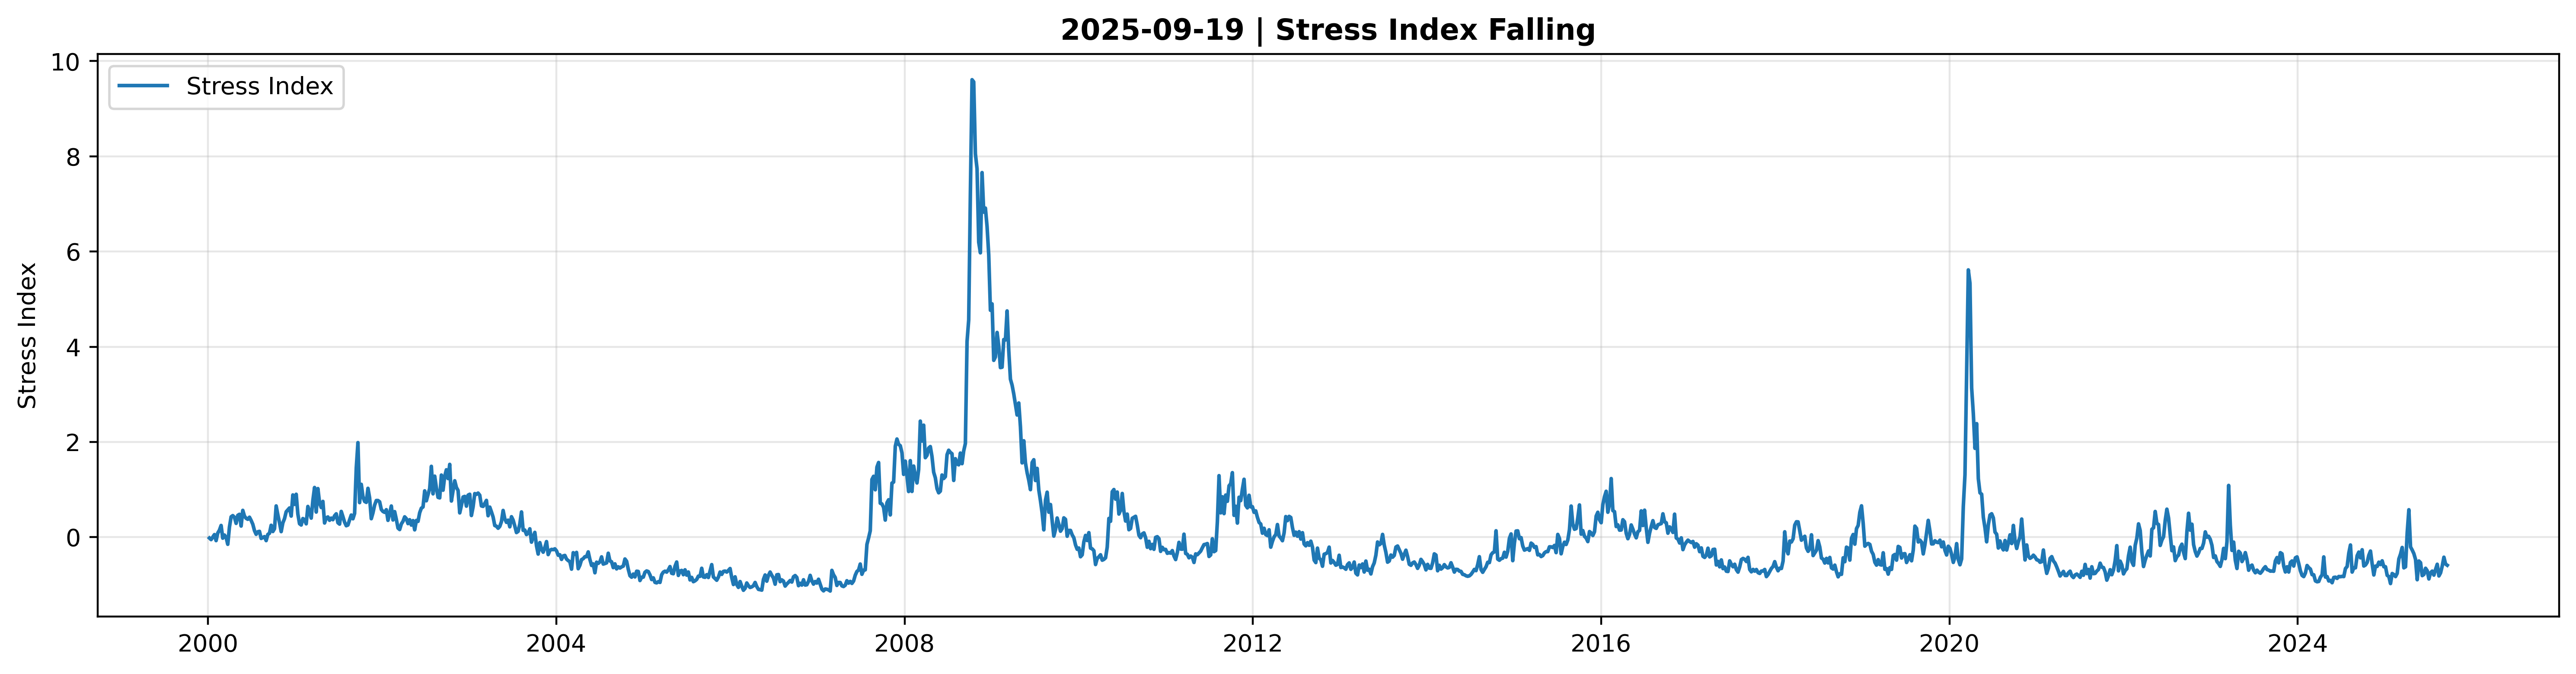

3820

In [15]:
df_stress = get_fred_series("STLFSI4", FRED_API_KEY)

plt.figure(figsize=(15, 4), dpi=400)

# Gold Price Chart
plt.plot(df_stress[START_DATE:].index, df_stress[START_DATE:]['value'],
         label='Stress Index', linewidth=1.5)
if df_stress.iloc[-1, 0] > df_stress.iloc[-2, 0]:
    plt.title(
        f'{df_stress.index[-1].strftime("%Y-%m-%d")} | Stress Index Rising', fontweight='bold')
else:
    plt.title(
        f'{df_stress.index[-1].strftime("%Y-%m-%d")} | Stress Index Falling', fontweight='bold')
plt.ylabel('Stress Index')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Industrial Production

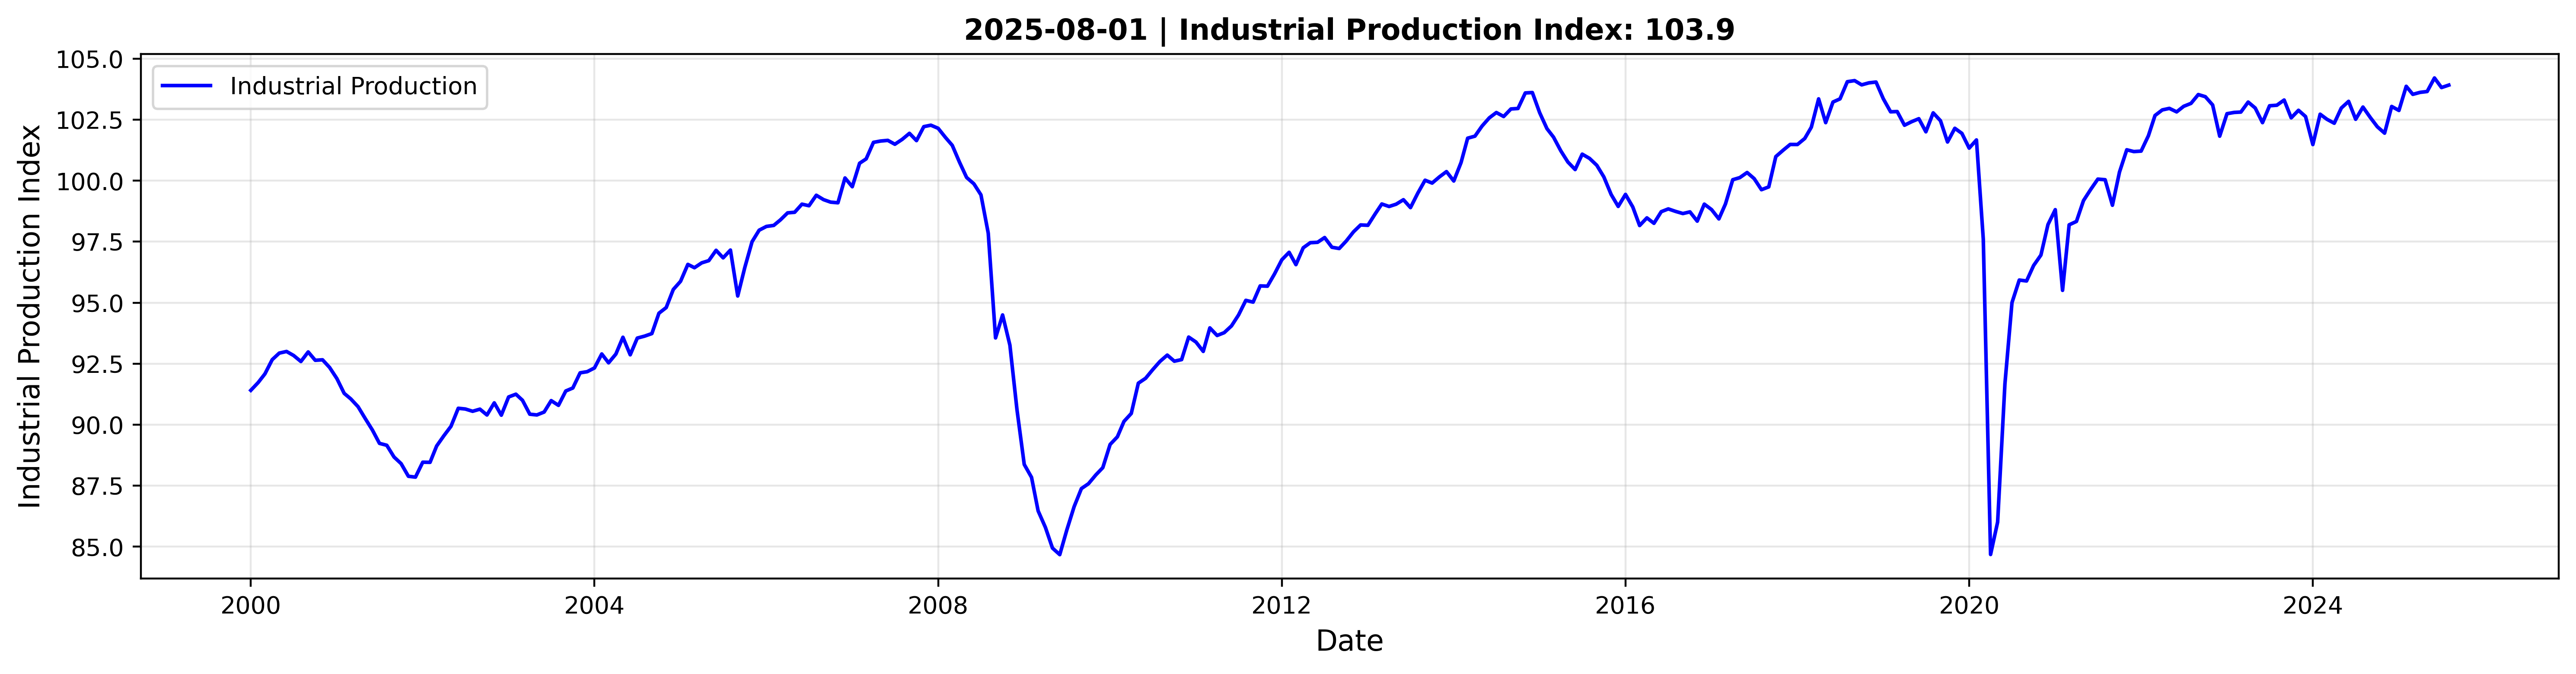

4160

In [16]:
# 산업생산지수 (Industrial Production)
df_industrial = get_fred_series("INDPRO", FRED_API_KEY)

plt.figure(figsize=(15, 4), dpi=400)
plt.plot(df_industrial[START_DATE:].index, df_industrial[START_DATE:]["value"], 
         label='Industrial Production', linewidth=1.5, color='blue')
plt.title(f'{df_industrial.index[-1].strftime("%Y-%m-%d")} | Industrial Production Index: {df_industrial.iloc[-1]["value"]:.1f}', fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Industrial Production Index', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()

# Mortgage Delinquency Rate

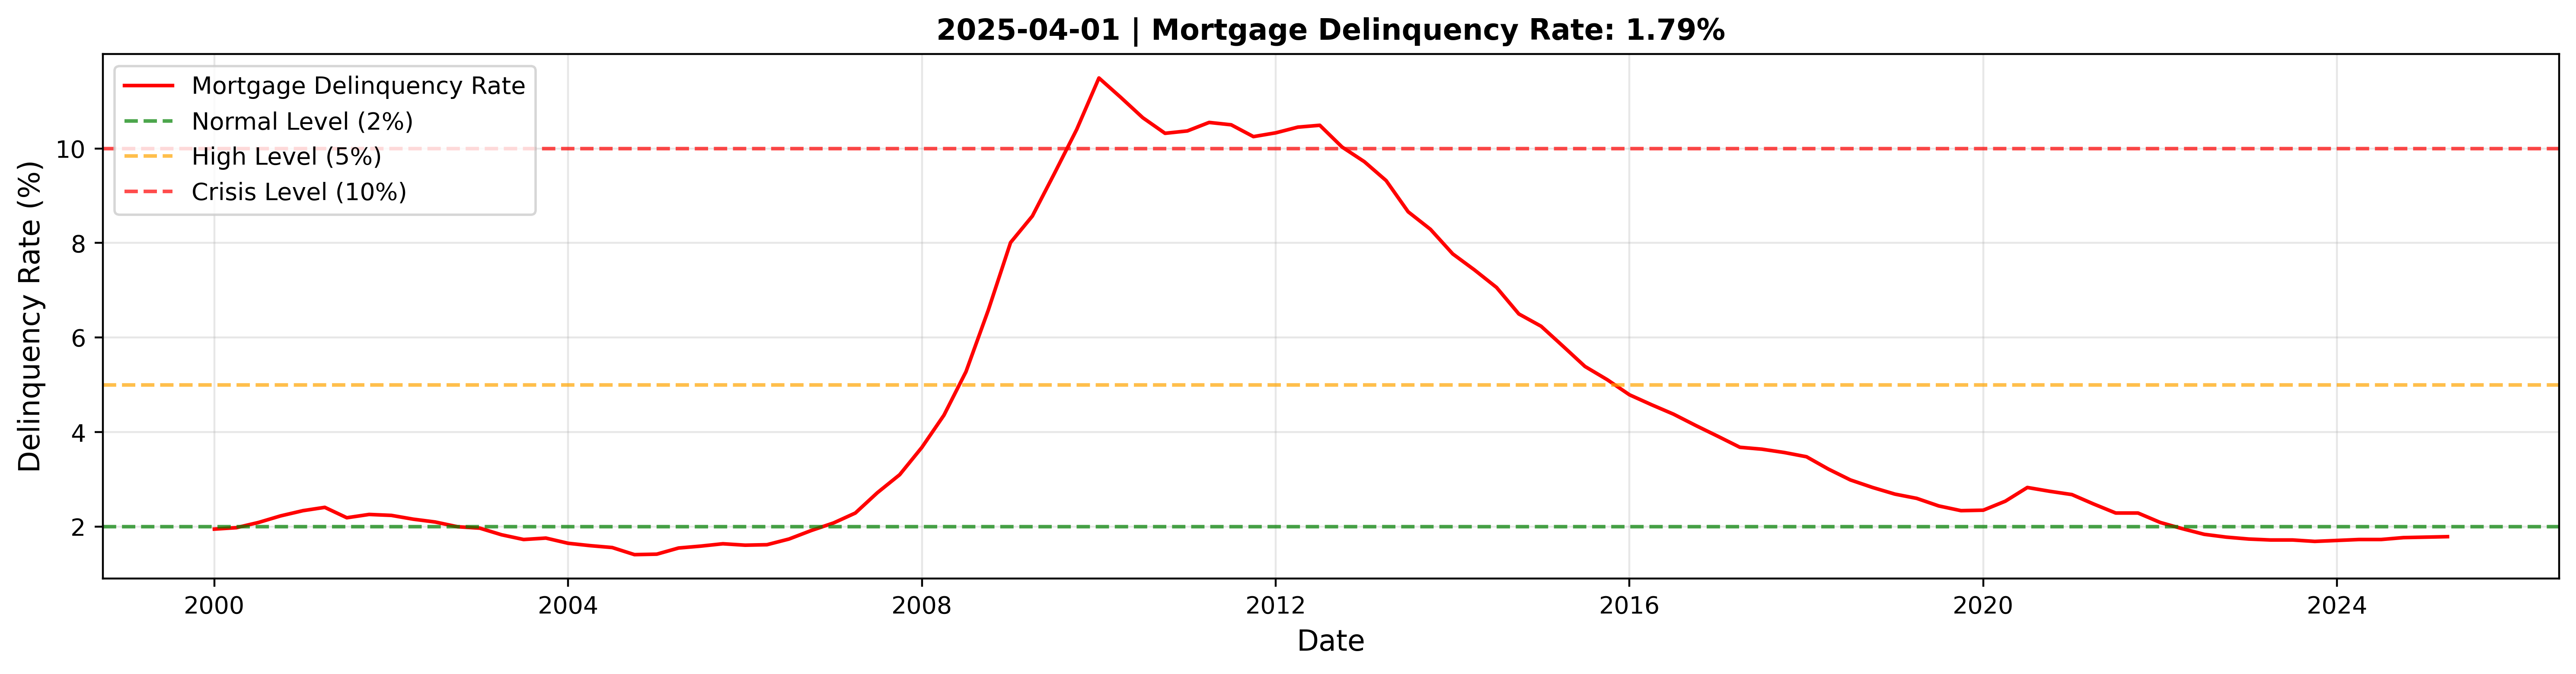

4285

In [17]:
# 주택담보대출 연체율 (Mortgage Delinquency Rate)
df_mortgage_delinq = get_fred_series("DRSFRMACBS", FRED_API_KEY)

plt.figure(figsize=(15, 4), dpi=400)
plt.plot(df_mortgage_delinq[START_DATE:].index, df_mortgage_delinq[START_DATE:]["value"], 
         label='Mortgage Delinquency Rate', linewidth=1.5, color='red')
plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.7, label='Normal Level (2%)')
plt.axhline(y=5.0, color='orange', linestyle='--', alpha=0.7, label='High Level (5%)')
plt.axhline(y=10.0, color='red', linestyle='--', alpha=0.7, label='Crisis Level (10%)')
plt.title(f'{df_mortgage_delinq.index[-1].strftime("%Y-%m-%d")} | Mortgage Delinquency Rate: {df_mortgage_delinq.iloc[-1]["value"]:.2f}%', fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Delinquency Rate (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gc.collect()